## Importación de librerías

In [3]:
%pip install -U scikit-learn

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.0.1 -> 26.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [4]:
%pip install -U category-encoders

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.0.1 -> 26.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [5]:
# Manipulación de datos
import numpy as np
import pandas as pd
import math

# Estadística y normalización
from scipy.stats import zscore
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, LabelEncoder
from category_encoders import TargetEncoder

# Visualización
import matplotlib.pyplot as plt
import seaborn as sns

## Carga de datos

In [6]:
df = pd.read_csv('dataset_estudiantes_EDA.csv', index_col=0)

df.head()

,nota_anterior,tasa_asistencia,horas_sueno,edad,nivel_dificultad,tiene_tutor,horario_estudio_preferido,estilo_aprendizaje,nota_final
horas_estudio_semanal,,,,,,,,,
8.957476,48.830601,86.640182,6.675694,25,Fácil,Sí,Tarde,Lectura/Escritura,84.4
11.042524,80.825707,83.449655,4.616844,18,Difícil,No,Tarde,NaN,72.0
4.510776,90.383694,74.623607,7.755246,25,Fácil,No,Mañana,Lectura/Escritura,80.0
6.647213,81.878257,82.849841,8.592826,23,Fácil,No,NaN,Visual,78.2
1.000000,66.254179,54.539935,6.671840,21,Medio,No,NaN,Auditivo,66.0


## Gestión de nulos

In [7]:
# Identificación de valores nulos en el DataFrame
cantidad_nulos = df.isna().sum()  # Suma valores nulos por columna
cantidad_nulos = cantidad_nulos[cantidad_nulos != 0]  # Filtra solo columnas con valores nulos

cantidad_nulos  # Muestra el resultado

horas_sueno                  150
horario_estudio_preferido    100
estilo_aprendizaje            50
dtype: int64

In [8]:
# Análisis de valores únicos en columnas categóricas con valores nulos
for col in cantidad_nulos.index.to_list():
    if col in df.select_dtypes(include='object'):
        display(df[col].value_counts())

horario_estudio_preferido
Noche     344
Tarde     337
Mañana    219
Name: count, dtype: int64

estilo_aprendizaje
Visual               363
Auditivo             254
Kinestésico          178
Lectura/Escritura    155
Name: count, dtype: int64

### Imputación de nulos

Para las columnas categóricas (como horario de estudio preferido y estilo de aprendizaje), se utiliza el valor genérico "Unknown" para reemplazar los valores nulos.
Para la columna numérica `horas_sueno`, se utiliza la mediana como medida de tendencia central para reemplazar los valores faltantes.

Esta estrategia de imputación preserva la integridad del conjunto de datos mientras proporciona un tratamiento apropiado según el tipo de variable, evitando la eliminación de filas con información parcialmente completa.

In [9]:
# Valor desconocido
val = 'Unknown'

# Columnas categoricas
cols_cat = ['horario_estudio_preferido', 'estilo_aprendizaje']

# Imputación de valores categóricos con un valor desconocido
df[cols_cat] = df[cols_cat].fillna(val)

# Imputación de valores numéricos con la mediana
df['horas_sueno'] = df['horas_sueno'].fillna(df['horas_sueno'].median())

In [10]:
# Comprobación de nulos
df.isna().sum().sum()

np.int64(0)

## Gestión outliers

### Identificación de outliers mediante boxplot

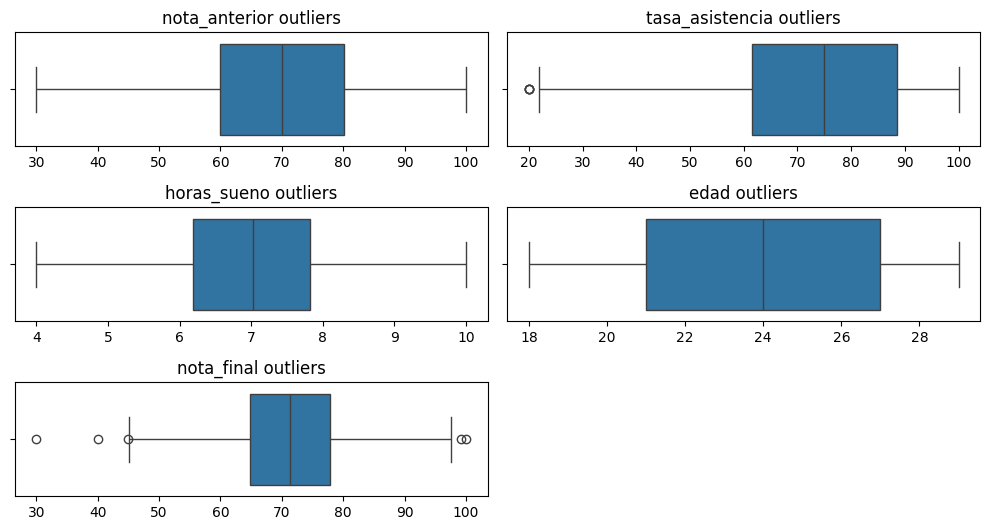

In [11]:
# Seleccionar solo columnas numéricas
df_num = df.select_dtypes(include=np.number)
cols_num = df_num.columns

# Calcular el número de gráficos
n_plots = len(cols_num)
num_rows = math.ceil(n_plots / 2)

# Tamaño de figura
figsize = (10, 1.8 * num_rows)

# Subplots
fig, axes = plt.subplots(nrows=num_rows, ncols=2, figsize=figsize)
axes = axes.flatten()

# Boxplot por variable
for i, col in enumerate(cols_num):
    sns.boxplot(data=df_num, x=col, ax=axes[i])
    axes[i].set_title(f"{col} outliers")
    axes[i].set_xlabel("")

# Eliminar ejes vacíos si sobran
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


- `nota_anterior`: La mayoría de notas anteriores se concentran aproximadamente entre 60 y 80, sin valores extremadamente raros y con una dispersión moderada.

- `tasa_asistencia`: La asistencia suele estar alta (sobre 60–90), pero aparece algún outlier muy bajo (en torno a 20) que indica casos puntuales de asistencia anormalmente baja.

- `horas_sueno`: Las horas de sueño se agrupan sobre 6–8 horas, con variación pequeña y sin outliers relevantes (valores bastante estables).

- `edad`: Las edades se concentran principalmente entre 21 y 27 años, sin outliers claros y con distribución bastante normal.

- `nota_final`: La nota final se agrupa cerca de 65–78, pero hay outliers tanto muy bajos (más o menos 30–45) como muy altos (100), mostrando algunos casos extremos de rendimiento.

### Detección de outliers mediante el método IQR

In [12]:
# Diccionario para almacenar los outliers detectados en cada columna
outliers_dict_iqr = {}

# Iterar sobre cada columna numérica
for col in df_num.columns:
   # Calcular los cuartiles Q1 y Q3
   Q1 = df_num[col].quantile(0.25)
   Q3 = df_num[col].quantile(0.75)
   IQR = Q3 - Q1  # Calcular el rango intercuartil

   # Definir los límites para detectar outliers (método de la valla)
   lower_bound = Q1 - 1.5 * IQR
   upper_bound = Q3 + 1.5 * IQR

   # Filtrar los outliers en la columna actual
   outliers = df_num[(df_num[col] < lower_bound) | (df_num[col] > upper_bound)]
   
   # Almacenar los outliers en el diccionario
   outliers_dict_iqr[col] = outliers

In [13]:
outliers_dict_iqr['tasa_asistencia']

,nota_anterior,tasa_asistencia,horas_sueno,edad,nota_final
horas_estudio_semanal,,,,,
10.207063,60.222635,20.000000,9.574623,19,65.7
9.072602,60.129355,20.000000,8.063128,29,64.5
6.209979,76.009529,20.050934,4.809203,23,65.0
1.000000,30.224020,20.000000,4.339117,23,50.8


In [14]:
outliers_dict_iqr['nota_final']

,nota_anterior,tasa_asistencia,horas_sueno,edad,nota_final
horas_estudio_semanal,,,,,
1.000000,37.046592,24.764175,5.722487,18,40.0
1.000000,30.000000,64.240392,7.973087,29,30.0
16.609729,100.000000,100.000000,8.754101,27,99.2
2.432055,75.362436,84.842736,7.156477,27,44.9
14.827102,100.000000,72.812698,7.646091,18,100.0


### Detección de outliers mediante el método Z-score

In [15]:
# Diccionario para almacenar los outliers detectados en cada columna
outliers_dict_z = {}

for col in df_num.columns:

    # Filtrar los outliers usando |Z| > 3
    outliers = df_num[np.abs(zscore(df_num[col])) > 3]

    # Almacenar los outliers en el diccionario
    outliers_dict_z[col] = outliers

outliers_df = pd.concat(outliers_dict_z.values(), keys=outliers_dict_z.keys())

In [16]:
outliers_dict_z['tasa_asistencia'].shape

(0, 5)

In [17]:
outliers_dict_z['nota_final'].shape

(2, 5)

---

## Para regresión

La variable objetivo es `nota_final`

In [18]:
# Hacemos una copia del DataFrame
df_reg = df.copy()

# Seleccionamos la variable objetivo
tv = 'nota_final'

### Codificación

In [19]:
cat_cols = df_reg.select_dtypes(include='O').columns.to_list()

In [20]:
cat_cols

['nivel_dificultad',
 'tiene_tutor',
 'horario_estudio_preferido',
 'estilo_aprendizaje']

Selección de los métodos de codificación

In [21]:
onehot_cols = ['nivel_dificultad', 'tiene_tutor', 'horario_estudio_preferido', 'estilo_aprendizaje']
target_cols = [x for x in cat_cols if x not in onehot_cols]

`OneHotEncoding`

Para convertir las columnas en binarias.

In [22]:
from sklearn.preprocessing import OneHotEncoder
import pandas as pd

# Asegurar nombres de columnas limpios (por si hay espacios invisibles)
df_reg.columns = df_reg.columns.str.strip()

# Si hay NaN en categóricas, evitar problemas y tratarlo como categoría
df_reg[onehot_cols] = df_reg[onehot_cols].astype("string").fillna("Desconocido")

# Validar que todas las columnas existen
missing = [c for c in onehot_cols if c not in df_reg.columns]
if missing:
    raise KeyError(
        f"Estas columnas no están en df_reg: {missing}\n"
        f"Columnas disponibles: {df_reg.columns.tolist()}"
    )

# Codificación OneHot 
onehot_encoder = OneHotEncoder(drop=None, sparse_output=False, handle_unknown='ignore')
onehot_encoded = onehot_encoder.fit_transform(df_reg[onehot_cols])

# Nombres de features (mejor con onehot_cols para que incluya prefijo de columna)
onehot_feature_names = onehot_encoder.get_feature_names_out(onehot_cols)

df_onehot = pd.DataFrame(onehot_encoded, columns=onehot_feature_names, index=df_reg.index)

# Concatenar con el DataFrame original y eliminar las columnas originales
df_reg = pd.concat([df_reg.drop(columns=onehot_cols), df_onehot], axis=1)



`TargetEncoding`

Para convertir las variables categóricas en números.

In [23]:
# Codificación Target Encoding para algunas variables categóricas con category_encoders
target_encoder = TargetEncoder(cols=target_cols)
df_reg[target_cols] = target_encoder.fit_transform(df_reg[target_cols], df_reg[tv])

### Escalado

`MinMaxScaler`

Para transformar las variables numéricas ajustando su rango a uno fijo, 0 y 1. 

In [24]:
scaler = MinMaxScaler()
df_reg[df_reg.drop(columns=[tv]).columns] = scaler.fit_transform(df_reg.drop(columns=[tv]))

### Guardamos el dataframe preprocesado

In [25]:
df_reg.to_csv('df_regresion.csv')

---

## Para clasificación

La variable objetivo es `aprobado`

In [26]:
# Hacemos una copia del DataFrame
df_clas = df.copy()

# Seleccionamos la variable objetivo
tv = 'aprobado'

### Codificación

In [27]:
cat_cols = df_clas.select_dtypes(include='O').columns.to_list()

Selección de los métodos de codificación

In [28]:
onehot_cols = ['horario_estudio_preferido', 'estilo_aprendizaje']

target_cols = []

label_cols = ['tiene_tutor', 'nivel_dificultad'] 

`OneHotEncoding`

Para convertir las columnas en binarias.

In [29]:
# Codificación OneHot
onehot_encoder = OneHotEncoder(drop=None, sparse_output=False, handle_unknown='ignore')
onehot_encoded = onehot_encoder.fit_transform(df_clas[onehot_cols])
onehot_feature_names = onehot_encoder.get_feature_names_out()
df_onehot = pd.DataFrame(onehot_encoded, columns=onehot_feature_names, index=df_clas.index)

# Concatenar con el DataFrame original y eliminar las columnas originales
df_clas = pd.concat([df_clas.drop(columns=onehot_cols), df_onehot], axis=1)

Variable objetivo a la que hacer target encoding

In [30]:
# Limpiamos nombres de columnas
df_clas.columns = df_clas.columns.str.strip()

# Creamos la variable 'aprobado' desde 'nota_final' con un umbral de 50.
UMBRAL = 50
df_clas["aprobado"] = (df_clas["nota_final"] >= UMBRAL).astype(int)

# Usamos aprobado como target
target_col = "aprobado"


`TargetEncoding`

Para convertir las variables categóricas en números.

In [31]:
# Codificación Target Encoding para algunas variables categóricas con category_encoders
target_encoder = TargetEncoder(cols=target_cols)
df_clas[target_cols] = target_encoder.fit_transform(df_clas[target_cols], df_clas[tv])

`LabelEncoding`

Para convertir las etiquetas categóricas en números enteros.

In [32]:
# Para LabelEncoding necesitamos aplicarlo a las columnas de una en una
df_clas[label_cols] = df_clas[label_cols].apply(lambda col: LabelEncoder().fit_transform(col))

### Escalado

`MinMaxScaler`

Para transformar las variables numéricas ajustando su rango a uno fijo, 0 y 1. 

In [33]:
scaler = MinMaxScaler()
df_clas[df_clas.columns] = scaler.fit_transform(df_clas)

### Guardamos el dataframe preprocesado

In [34]:
df_clas.to_csv('df_clasificacion.csv')